# HW 1: Building a Small GPT Model

Welcome to the first (and last) wet assignment!

In this notebook, we will be building a small version of the GPT model.

- This notebook is divided into several sections, each with a specific task.
- You will find within each cell the place where you are expected to write your code. **Do not change any code outside of this area.**
- Each exercise will be in an already defined class or function, with documentation of what it does.
- Make sure to read the class or function documentation carefully.


For example:

        Some Code
        # ======= Your Code Starts Here ========
                        |
                        |
                Write your code here
                        |
                        |
        # ======= Your Code Ends Here ========
        Some Code

- We recommend using Google Colab with a free GPU to enhance the training speed, but it is not necessary.
- Remember, the goal of this assignment is not just to get the correct output, but to understand the process of building and training a GPT model. Don't hesitate to ask questions if you're unsure about anything.
- We are here to help. If you have any questions, please post them on the relevant section in Piazza: https://piazza.com/technion.ac.il/winter2024/236004

Good luck!

# Setup

In [1]:
        # ======= Your Code Starts Here ========
!pip install datasets
        # ======= Your Code Ends Here ========


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from transformers import GPT2Tokenizer, get_linear_schedule_with_warmup
from tqdm import tqdm
from typing import Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Part 1 Attention (30 points)

## Part 1.1 Attention Head (20 points)

In [3]:
class AttentionHead(nn.Module):
    """
    This class represents an attention head for transformer models.
    """

    def __init__(self, d_input: int, n_hidden: int):
        """
        Initializes the AttentionHead.

        Args:
            d_input: the dimension of the input
            n_hidden: the dimension of the keys, queries, and values
        """
        super().__init__()
        self.W_K = nn.Linear(d_input, n_hidden)
        self.W_Q = nn.Linear(d_input, n_hidden)
        self.W_V = nn.Linear(d_input, n_hidden)
        self.n_hidden = n_hidden

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Computes the forward pass of the attention head.

        Args:
            x (torch.Tensor): The input tensor. Shape: (batch_size, seq_length, d_input)
            attn_mask (Optional[torch.Tensor]): The causal mask tensor. If provided, it acts as an attention mask
            that determines which tokens in the sequence should be attended to. It's a 3D tensor where the value at
            position [b, i, j] is 1 if the token at position i in batch b should attend to the token at position j,
            and 0 otherwise. If not provided (None), ignore it.
            Shape: (batch_size, seq_length, seq_length)

        Returns:
            attn_output (torch.Tensor): The output tensor after attention. Shape: (batch_size, seq_length, n_hidden)
            attn_score (torch.Tensor): The attention score tensor. Shape: (batch_size, seq_length, seq_length)
        """
        attn_output, attn_score = None, None
        # ======= Your Code Starts Here ========
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        K_transpose = K.transpose(-2, -1)

        score = torch.bmm(Q, K_transpose)/np.sqrt(self.n_hidden)

        if attn_mask is not None:
            score = score.masked_fill(attn_mask == 0, float('-inf'))
        
        attn_score = torch.nn.functional.softmax(score, dim=-1)

        attn_output = torch.matmul(attn_score, V)

        # ======= Your Code Ends Here ========

        return attn_output, attn_score

## Part 1.2 Multihead Attention (10 points)

In [4]:
class MultiheadAttention(nn.Module):
    def __init__(self, d_input: int, n_hidden: int, num_heads: int):
        """
        Initializes the MultiheadAttention.

        Args:
            d_input (int): The dimension of the input.
            n_hidden: the hidden dimenstion for the attention layer
            num_heads (int): The number of attention heads.
        Attributes:
            attention_heads (nn.ModuleList): A list of attention heads.
            W_proj (nn.Linear): A linear layer for projecting the concatenated outputs of the attention heads back
            to the original dimension.
        """

        super().__init__()

        # ======= Your Code Starts Here ========
        self.attention_heads = nn.ModuleList([AttentionHead(d_input, n_hidden) for i in range(num_heads)])
        self.W_proj = nn.Linear(num_heads*n_hidden, d_input)

        # ======= Your Code Ends Here ========

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Executes the forward pass of the multi-head attention mechanism.

        Args:
            x (torch.Tensor): The input tensor. It has a shape of (batch_size, seq_length, d_input).
            attn_mask (Optional[torch.Tensor]): The attention mask tensor. If provided, it serves as an attention guide
            that specifies which tokens in the sequence should be attended to. It's a 3D tensor where the value at
            position [b, i, j] is 1 if the token at position i in batch b should attend to the token at position j,
            and 0 otherwise. If not provided (None), ignore it.
            Shape: (batch_size, seq_length, seq_length)

        Returns:
            attn_output (torch.Tensor): The output tensor after applying multi-head attention. It has a shape of
            (batch_size, seq_length, d_input).

        This method computes the multi-head attention by looping through each attention head, collecting the outputs,
        concatenating them together along the hidden dimension, and then projecting them back into the output dimension
        (d_input). It returns both the final attention outputs as well as the attn_scores from each head.
        """
        attn_output, attn_scores = None, None

        # ======= Your Code Starts Here ========
        attn_outputs = []
        attn_scores = []

        # Loop through each attention head
        for head in self.attention_heads:
            output, score = head(x, attn_mask)
            attn_outputs.append(output)
            attn_scores.append(score)

        # Concatenate the outputs of the attention heads
        attn_output = torch.cat(attn_outputs, dim=-1) 

        # Project the concatenated outputs back to the original dimension
        attn_output = self.W_proj(attn_output) 

        attn_scores = torch.stack(attn_scores, dim=1)

        # ======= Your Code Ends Here ========
        return attn_output, attn_scores

# Part 2 GPT (30 points)

## Part 2.1 Tranformer Block (5 points)

In [5]:
# FFN class is alreay implemented for you
class FFN(nn.Module):
    """
    This class represents a Feed-Forward Network (FFN) layer.
    """
    def __init__(self, d_input: int, n_hidden: int):
        """
        Args:
            d_input (int): The dimension of the input.
            n_hidden (int): The hidden dimension for the FFN.
        Attributes:
            ffn (nn.Sequential): A sequential container of the FFN layers.
        """

        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(d_input, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, d_input),
        )

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        """
        Executes the forward pass of the FFN.

        Args:
            x (torch.Tensor): The input tensor. Shape: (batch_size, seq_length, d_input)

        Returns:
            out (torch.Tensor): The output tensor of the FFN. Shape: (batch_size, seq_length, d_input)
        """
        return self.ffn(x)


class TransformerBlock(nn.Module):
    """
    This class represents a Transformer block.
    """
    def __init__(self, d_input: int, attn_dim: int, mlp_dim: int, num_heads: int):
        """
        Args:
            d_input (int): The dimension of the input.
            attn_dim (int): The hidden dimension for the attention layer.
            mlp_dim (int): The hidden dimension for the FFN.
            num_heads (int): The number of attention heads.

        Attributes:
            layer_norm_1 (nn.LayerNorm): The first layer normalization layer for the attention.
            layer_norm_2 (nn.LayerNorm): The second layer normalization layer for the FFN.
            attention (MultiheadAttention): The multi-head attention mechanism.
            ffn (FFN): The feed-forward network.
        """
        super().__init__()
        # ======= Your Code Starts Here ========
        self.attention = MultiheadAttention(d_input, attn_dim, num_heads)
        self.layer_norm_1 = nn.LayerNorm(d_input)

        self.ffn = FFN(d_input, mlp_dim)
        self.layer_norm_2 = nn.LayerNorm(d_input)
        # ======= Your Code Ends Here ========

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Executes the forward pass of the Transformer block.

        Args:
            x (torch.Tensor): The input tensor. Shape: (batch_size, seq_length, d_input)
            attn_mask (torch.Tensor): The attention mask tensor. If provided, it serves as an attention guide
            that specifies which tokens in the sequence should be attended to. It's a 3D tensor where the value at
            position [b, i, j] is 1 if the token at position i in batch b should attend to the token at position j,
            and 0 otherwise. If not provided (None), no specific attention pattern is enforced.
            Shape: (batch_size, seq_length, seq_length)

        Returns:
            x (torch.Tensor): The output tensor after passing through the Transformer block. Shape: (batch_size, seq_length, d_input)
            attn_scores (torch.Tensor): The attention weights of each of the attention heads. Shape: (batch_size, num_heads, seq_length, seq_length)
        """
        attn_scores = None
        # ======= Your Code Starts Here ========
        
        # produce contextualized representations
        attn_output, attn_scores = self.attention(x, attn_mask)

        # add residual connection to the self attention and normalize
        x = self.layer_norm_1(x + attn_output)

        # produce output of the feed forward layer
        ffn_output = self.ffn(x)
        
        # add residual connection and normalize
        x = self.layer_norm_2(x + ffn_output)

        # ======= Your Code Ends Here ========
        return x, attn_scores

## Part 2.2 Transformer (10 points)

In [6]:
class Transformer(nn.Module):
    def __init__(self, d_input: int, attn_dim: int, mlp_dim: int, num_heads: int, num_layers: int):
        """
        Initializes the Transformer.

        Args:
            d_input (int): The dimension of the input.
            attn_dim (int): The hidden dimension of the attention layer.
            mlp_dim (int): The hidden dimension of the FFN layer.
            num_heads (int): The number of heads in the attention layer.
            num_layers (int): The number of attention layers.

        Attributes:
            transformer_blocks (nn.ModuleList): A list of Transformer blocks.
        """

        super().__init__()
        self.transformer_blocks = None
        # ======= Your Code Starts Here ========
        self.transformer_blocks = nn.ModuleList([TransformerBlock(d_input, attn_dim, mlp_dim, num_heads) for _ in range(num_layers)])
        # ======= Your Code Ends Here ========

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor, return_attn=False)-> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Executes the forward pass of the GPT model.

        Args:
            x (torch.Tensor): The input tensor. Shape: (batch_size, seq_length, d_input)
            attn_mask (torch.Tensor): The attention mask tensor. Shape: (batch_size, seq_length, seq_length)
            return_attn (bool): If True, return the attention weights of each of the attention heads for each of the layers.

        Returns:
            output (torch.Tensor): The output tensor after passing through the GPT model. Shape: (batch_size, seq_length, d_input)
            collected_attns (Optional[torch.Tensor]): If return_attn is False, return None. Otherwise return the attention weights
            of each of each of the attention heads for each of the layers. Shape: (batch_size, num_layers, num_heads, seq_length, seq_length)
        """
        output, collected_attns = None, None
        # ======= Your Code Starts Here ========
        attn_scores = []
        output = x
        for block in self.transformer_blocks:
            output, attn_score = block(output, attn_mask)
            attn_scores.append(attn_score)

        if return_attn:
            # Flatten the list of lists to a single list of tensors
            collected_attns = torch.stack(attn_scores, dim=1)
        else :
            collected_attns = None

        # ======= Your Code Ends Here ========
        return output, collected_attns

## Run Transformer Tests (no implementation needed)

In [7]:
def run_transformer_tests():
    # Define parameters
    n_ctx = 16
    batch_size = 4
    d_input = 32
    d_embed = 64
    n_layers = 4
    n_heads = 4
    attn_dim = d_embed // n_heads
    mlp_dim = d_input * 4

    # Initialize the model
    model = Transformer(d_input=d_input, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=n_heads, num_layers=n_layers).to(device)

    # Create a random input tensor
    input_tensor = torch.randn(batch_size, n_ctx, d_input).to(device)

    # Test Case 1: Regular forward pass
    print("Test Case 1: Regular forward pass")
    with torch.no_grad():
        output_tensor, attention_weights = model(input_tensor, attn_mask=None)
        assert attention_weights is None
        assert output_tensor.shape == (batch_size, n_ctx, d_input), f"Unexpected output shape {output_tensor.shape}"
    print("Test Case 1 Passed!")

    # Test Case 2: Collect attentions
    print("Test Case 2: Collect attentions")
    with torch.no_grad():
        output_tensor, attention_weights = model(input_tensor, attn_mask=None, return_attn=True)
        assert output_tensor.shape == (batch_size, n_ctx, d_input), f"Unexpected output shape {output_tensor.shape}"
        assert attention_weights.shape == (batch_size, n_heads, n_heads, n_ctx, n_ctx), f"Unexpected attention weights shape {attention_weights.shape}"
    print("Test Case 2 Passed!")

    # Test Case 3: With attention mask
    print("Test Case 3: With attention mask")
    attention_mask = torch.zeros(batch_size, n_ctx, n_ctx).to(device)
    attention_mask[:, torch.arange(n_ctx), torch.arange(n_ctx)] = 1
    attention_mask[:, torch.arange(n_ctx)[1:], torch.arange(n_ctx)[:-1]] = 1

    with torch.no_grad():
        output_tensor, attention_weights = model(input_tensor, attn_mask=attention_mask, return_attn=True)
        assert torch.all(attention_weights.permute(1, 2, 0, 3, 4)[:, :, attention_mask == 0] == 0).item()
    print("Test Case 3 Passed!")

# Run the test cases
run_transformer_tests()

Test Case 1: Regular forward pass
Test Case 1 Passed!
Test Case 2: Collect attentions
Test Case 2 Passed!
Test Case 3: With attention mask
Test Case 3 Passed!


## Configs (no implementation needed)

In [8]:
class ModelConfig:
    def __init__(self, d_embed: int = 192, debug: bool = False, layer_norm_eps: float = 1e-5,
                 d_vocab: int = 50257 + 1, n_ctx: int = 32, n_heads: int = 4, n_layers: int = 4):
        self.d_embed = d_embed
        self.debug = debug
        self.layer_norm_eps = layer_norm_eps
        self.d_vocab = d_vocab
        self.n_ctx = n_ctx
        self.n_heads = n_heads
        self.d_head = self.d_embed // self.n_heads
        self.n_layers = n_layers

    def __repr__(self):
        return '\n'.join([f'{k}: {v}' for k, v in self.__dict__.items()])

class TrainConfig:
    def __init__(self, batch: int = 4, epochs: int = 10, lr: float = 5e-4, warmup_steps_ratio: float = 0.1,
                 device: torch.device = device):
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        self.warmup_steps_ratio = warmup_steps_ratio
        self.device = device

    def __repr__(self):
        return '\n'.join([f'{k}: {v}' for k, v in self.__dict__.items()])

## Part 2.3 Embedding (5 points)

In [9]:
class Embed(nn.Module):
    def __init__(self, config: ModelConfig):
        """
        Args:
            config (ModelConfig): The model configuration.
        """
        super().__init__()
        self.d_embed = config.d_embed
        self.d_vocab = config.d_vocab
        self.embed = nn.Embedding(self.d_vocab, self.d_embed, device=device)
    def forward(self, input_ids):
        return self.embed(input_ids)

# Implement learnt positional encoding
class PosEmbed(nn.Module):
    def __init__(self, config: ModelConfig):
        """
        Args:
            config (ModelConfig): The model configuration.
        """
        super().__init__()
        self.d_embed = config.d_embed
        self.n_ctx = config.n_ctx
        self.pos_embed = nn.Embedding(self.n_ctx, self.d_embed, device=device)

    def forward(self, input_ids):
        indices = None
        # ======= Your Code Starts Here ========
        indices = torch.arange(input_ids.shape[1], device=device).unsqueeze(0).repeat(input_ids.shape[0], 1)
        # ======= Your Code Ends Here ========
        return self.pos_embed(indices)

## Part 2.4 GPT (10 points)

In [10]:
class GPT(nn.Module):
    def __init__(self, config: ModelConfig, Embed: nn.Module, PosEmbed: nn.Module):
        """
        Initializes the GPT model.

        Args:
            config (ModelConfig): The model configuration.
            Embed (nn.Module): The embedding layer.
            PosEmbed (nn.Module): The positional embedding layer.
        """
        super().__init__()
        self.d_vocab = config.d_vocab
        self.n_ctx = config.n_ctx
        self.d_embed = config.d_embed
        self.attn_dim = config.d_head
        self.mlp_dim = config.d_embed * 4
        self.num_heads = config.n_heads
        self.num_layers = config.n_layers

        self.token_embedding = Embed(config)
        self.positional_embedding = PosEmbed(config)

        self.transformer = Transformer(
            d_input=self.d_embed, attn_dim=self.attn_dim, mlp_dim=self.mlp_dim, num_heads=self.num_heads, num_layers=self.num_layers)

        # ======= Your Code Starts Here ========
        self.ln_f = nn.LayerNorm(self.d_embed, eps=config.layer_norm_eps)

        self.head = nn.Linear(self.d_embed, self.d_vocab, bias=False)
        # ======= Your Code Ends Here ========

    def forward(self, input_ids: torch.Tensor, return_attn=False) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Executes the forward pass of the GPT model.

        Args:
            input_ids (torch.Tensor): A batch of input ids (right padded). Shape: (batch_size x seq_length).
            return_attn (bool): If True, return the attention weights of each of the attention heads for each of the layers.

        Returns:
            out (torch.Tensor): The logit vector. Shape: (batch_size x seq_length x vocab_size).
            attn_scores (Optional[torch.Tensor]): If return_attn is False, return None. Otherwise return the attention weights
            of each of each of the attention heads for each of the layers. Shape: (batch_size, num_layers, num_heads, seq_length, seq_length).
        """
        out, attn_scores = None, None
        # ======= Your Code Starts Here ========
        token_embed = self.token_embedding(input_ids)

        # Get the positional embeddings
        positional_embed = self.positional_embedding (input_ids)

        # Sum the token embeddings and positional embeddings
        x = token_embed + positional_embed

        # Pass the embeddings through the transformer
        x, attn_scores = self.transformer(x, attn_mask=None, return_attn=return_attn)

        # Apply the final layer normalization
        x = self.ln_f(x)

        # Apply the linear layer
        out = self.head(x)
        # ======= Your Code Ends Here ========
        return out, attn_scores

## Generating (no implementation needed)

In [11]:
model_config = ModelConfig()
train_config = TrainConfig()

# Load the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', max_length=model_config.n_ctx)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token = '[PAD]'

In [12]:
def generate(model, tokenizer, prompt, max_len=10):
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    generated_tokens = input_ids.to(device)

    for _ in range(max_len):
        with torch.no_grad():
            outputs, _ = model(generated_tokens)
        next_token = torch.argmax(outputs[:, -1, :], dim=-1).unsqueeze(-1)
        generated_tokens = torch.cat((generated_tokens, next_token), dim=-1)

    generated_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=False)
    return generated_text

# Training (no implementation needed)

In [13]:
def train(model: nn.Module, dataloader, optimizer, scheduler, criterion, train_config: TrainConfig):
    for epoch in range(train_config.epochs):
        epoch_loss = 0
        with tqdm(dataloader, unit="batch") as tepoch:
            for batch in tepoch:
                input_ids = batch['input_ids'].to(device)
                optimizer.zero_grad()

                # Forward pass
                outputs, _ = model(input_ids[:, :-1])
                loss = criterion(outputs.view(-1, outputs.size(-1)), input_ids[:, 1:].reshape(-1))
                # Backward pass
                loss.backward()
                optimizer.step()
                scheduler.step()

                epoch_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

        epoch_loss /= len(dataloader)
        print(f"Epoch: {epoch}, Loss: {epoch_loss:0.4f}, LR: {scheduler.get_last_lr()[0]:0.4e}")

# Testing (no implementation needed)

In [14]:
def test(model: nn.Module, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, unit="batch"):
            input_ids = batch['input_ids'].to(device)
            outputs, _ = model(input_ids[:, :-1])
            loss = criterion(outputs.view(-1, outputs.size(-1)), input_ids[:, 1:].reshape(-1))
            total_loss += loss.item()
    total_loss /= len(dataloader)
    print(f"Loss: {total_loss:0.4f}")
    if total_loss < 5.5:
        print("Test Passed!")
    else:
        print("Test Failed!, Loss is too high")

## Model training sanity check

In [15]:
# Run me for sanity check of the model

# Note that this is not a comprehensive test of the model, and if it pass this test, it does not mean your model is correct.
# Even if it does memorize the training set, it does not necessarily mean the model is implemented correctly.
# You should check the loss and generated text to see if it makes sense and preferably create your own tests.

def sanity_check():
    """
    Runs a sanity check to ensure the model can overfit on a small dataset.
    """
    # Configure the model and training
    model_config = ModelConfig()
    train_config = TrainConfig(batch=1, epochs=20, lr=5e-4)

    # Prepare the data
    sentence = "This course is so much fun! I wish it was longer."
    inputs = tokenizer(sentence, return_tensors='pt')
    dataset = Dataset.from_dict({'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask']})
    dataset = dataset.with_format("torch", device=train_config.device)
    data_loader = DataLoader(dataset, batch_size=train_config.batch, shuffle=False)

    model = GPT(model_config, Embed, PosEmbed).to(device)

    # Set up the optimizer, loss function, and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=train_config.lr, weight_decay=0)
    steps = int((train_config.epochs * len(data_loader)) / train_config.batch)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=steps)

    # Train the model
    train(model, data_loader, optimizer, scheduler, loss_fn, train_config)

    # Test the model's ability to memorize a sentence
    print("\n\t ~~~~~~~~ The model should be able to memorize the sentence from the training set ~~~~~~~~")

    generated = generate(model, tokenizer, prompt="This course", max_len=12)
    print(f"\nOriginal:\n\"{sentence}\"\n")
    print(f"\nGenerated:\n\"{generated}\"\n")
sanity_check()

100%|██████████| 1/1 [00:00<00:00,  6.72batch/s, loss=11.1]


Epoch: 0, Loss: 11.1405, LR: 4.7500e-04


100%|██████████| 1/1 [00:00<00:00, 19.06batch/s, loss=9.36]


Epoch: 1, Loss: 9.3613, LR: 4.5000e-04


100%|██████████| 1/1 [00:00<00:00, 19.30batch/s, loss=7.95]


Epoch: 2, Loss: 7.9547, LR: 4.2500e-04


100%|██████████| 1/1 [00:00<00:00, 19.17batch/s, loss=6.9]


Epoch: 3, Loss: 6.8970, LR: 4.0000e-04


100%|██████████| 1/1 [00:00<00:00, 19.43batch/s, loss=6.07]


Epoch: 4, Loss: 6.0690, LR: 3.7500e-04


100%|██████████| 1/1 [00:00<00:00, 19.22batch/s, loss=5.39]


Epoch: 5, Loss: 5.3901, LR: 3.5000e-04


100%|██████████| 1/1 [00:00<00:00, 14.64batch/s, loss=4.83]


Epoch: 6, Loss: 4.8348, LR: 3.2500e-04


100%|██████████| 1/1 [00:00<00:00, 19.55batch/s, loss=4.39]


Epoch: 7, Loss: 4.3929, LR: 3.0000e-04


100%|██████████| 1/1 [00:00<00:00, 19.38batch/s, loss=4.05]


Epoch: 8, Loss: 4.0468, LR: 2.7500e-04


100%|██████████| 1/1 [00:00<00:00, 19.47batch/s, loss=3.77]


Epoch: 9, Loss: 3.7732, LR: 2.5000e-04


100%|██████████| 1/1 [00:00<00:00, 19.53batch/s, loss=3.55]


Epoch: 10, Loss: 3.5527, LR: 2.2500e-04


100%|██████████| 1/1 [00:00<00:00, 19.61batch/s, loss=3.37]


Epoch: 11, Loss: 3.3719, LR: 2.0000e-04


100%|██████████| 1/1 [00:00<00:00, 19.30batch/s, loss=3.22]


Epoch: 12, Loss: 3.2227, LR: 1.7500e-04


100%|██████████| 1/1 [00:00<00:00, 19.23batch/s, loss=3.1]


Epoch: 13, Loss: 3.0996, LR: 1.5000e-04


100%|██████████| 1/1 [00:00<00:00, 19.14batch/s, loss=3]


Epoch: 14, Loss: 2.9988, LR: 1.2500e-04


100%|██████████| 1/1 [00:00<00:00, 13.63batch/s, loss=2.92]


Epoch: 15, Loss: 2.9175, LR: 1.0000e-04


100%|██████████| 1/1 [00:00<00:00, 18.78batch/s, loss=2.85]


Epoch: 16, Loss: 2.8530, LR: 7.5000e-05


100%|██████████| 1/1 [00:00<00:00, 18.53batch/s, loss=2.8]


Epoch: 17, Loss: 2.8036, LR: 5.0000e-05


100%|██████████| 1/1 [00:00<00:00, 19.04batch/s, loss=2.77]


Epoch: 18, Loss: 2.7677, LR: 2.5000e-05


100%|██████████| 1/1 [00:00<00:00, 19.17batch/s, loss=2.74]


Epoch: 19, Loss: 2.7444, LR: 0.0000e+00

	 ~~~~~~~~ The model should be able to memorize the sentence from the training set ~~~~~~~~

Original:
"This course is so much fun! I wish it was longer."


Generated:
"This course is so much fun! I wish it was longer. anterior"



## Dataset (no implementation needed)

In [16]:
wiki_10k = load_dataset("NeelNanda/wiki-10k")
data = wiki_10k['train']

Using custom data configuration NeelNanda--wiki-10k-b12f3c3fb7eca139
Found cached dataset parquet (/Users/benjaminc/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--wiki-10k-b12f3c3fb7eca139/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
def tokenize(example):
    return tokenizer(example['text'], max_length=model_config.n_ctx, padding=True, truncation=True, return_tensors='pt')
cols_to_remove = list(data.features.keys())
dataset = data.map(tokenize, batched=True, remove_columns=cols_to_remove)
dataset = dataset.with_format("torch", device=train_config.device)

Loading cached processed dataset at /Users/benjaminc/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--wiki-10k-b12f3c3fb7eca139/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-195735f81958b73a.arrow


In [18]:
splitted_dataset = dataset.train_test_split(test_size=0.1, shuffle=True, seed=42)
train_dataset, test_dataset = splitted_dataset['train'], splitted_dataset['test']
train_dataloader = DataLoader(train_dataset, batch_size=train_config.batch, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=train_config.batch, shuffle=False)

Loading cached split indices for dataset at /Users/benjaminc/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--wiki-10k-b12f3c3fb7eca139/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-b80deaa87cd484d4.arrow and /Users/benjaminc/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--wiki-10k-b12f3c3fb7eca139/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-4f75efe13ee26caa.arrow


## Model Initialization and Configuration (no implementation needed)

In [19]:
model = GPT(model_config, Embed, PosEmbed).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=train_config.lr, weight_decay=0)
num_training_steps = int((train_config.epochs * len(train_dataloader)) / train_config.batch)
criterion = nn.CrossEntropyLoss()
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=train_config.warmup_steps_ratio * num_training_steps,
    num_training_steps=num_training_steps)

In [72]:
train(model, train_dataloader, optimizer, scheduler, criterion, train_config)

100%|██████████| 2250/2250 [02:44<00:00, 13.69batch/s, loss=1.57] 


Epoch: 0, Loss: 4.2278, LR: 3.3333e-04


100%|██████████| 2250/2250 [02:46<00:00, 13.55batch/s, loss=0.711]


Epoch: 1, Loss: 1.0571, LR: 1.1111e-04


100%|██████████| 2250/2250 [02:44<00:00, 13.72batch/s, loss=0.961]


Epoch: 2, Loss: 0.6062, LR: 0.0000e+00


100%|██████████| 2250/2250 [02:42<00:00, 13.80batch/s, loss=0.345]


Epoch: 3, Loss: 0.5627, LR: 0.0000e+00


100%|██████████| 2250/2250 [02:45<00:00, 13.57batch/s, loss=0.552]


Epoch: 4, Loss: 0.5627, LR: 0.0000e+00


100%|██████████| 2250/2250 [02:44<00:00, 13.68batch/s, loss=0.528]


Epoch: 5, Loss: 0.5627, LR: 0.0000e+00


100%|██████████| 2250/2250 [02:44<00:00, 13.64batch/s, loss=0.589]


Epoch: 6, Loss: 0.5627, LR: 0.0000e+00


100%|██████████| 2250/2250 [02:46<00:00, 13.55batch/s, loss=0.227]


Epoch: 7, Loss: 0.5627, LR: 0.0000e+00


100%|██████████| 2250/2250 [02:44<00:00, 13.68batch/s, loss=0.488]


Epoch: 8, Loss: 0.5627, LR: 0.0000e+00


100%|██████████| 2250/2250 [02:45<00:00, 13.59batch/s, loss=0.567]

Epoch: 9, Loss: 0.5627, LR: 0.0000e+00


# Part 3.0 - Exploration & Questions (40 points)

## Part 3.1 Hyper Paramaters Search (15 points)

### Question (5 points)
Explore other hyper-parameters (by editing ModelConfig and TrainConfig).\
Try at least 3 different configurations and describe shortly your insights.

### Answer:

The loss for the default parameters of the model is loss = 1.0794.


A few experiments and the corresponding loss:

- train_config.lr = 0.001; **loss = 0.79**

- train_config.lr = 0.005; **loss = 7.5142**

- train_config.lr = 0.002; **loss = 0.7321**

- train_config.batch = 8; **loss = 1.9876**

- train_config.batch = 16; **loss = 3.5494**

- train_config.batch = 8; train_config.lr = 0.002; **loss = 0.8949**

- train_config.batch = 6; train_config.lr = 0.0015; train_config.epochs = 5; **loss = 1.3483**

- train_config.batch = 6; train_config.lr = 0.0015; train_config.epochs = 5; **loss = 1.3387**

It seems that each parameter could reach separately optimal values for the loss. Optimizing with a combination of them seems more diffcult and would require an optimization algorithm. 

For example, the optimal value for the learning rate seems to be around 0.002.

In [50]:
# print default config values
print(model_config)
print()
print(train_config)

d_embed: 192
debug: False
layer_norm_eps: 1e-05
d_vocab: 50258
n_ctx: 32
n_heads: 4
d_head: 48
n_layers: 4

batch: 4
epochs: 10
lr: 0.002
warmup_steps_ratio: 0.1
device: cpu


In [49]:
# change the configs as you wish to explore how different hyperparameters affect the model training and performance
model_config = ModelConfig()
train_config = TrainConfig()
# ======= Your Code Starts Here ========
train_config.batch = 6
train_config.lr = 0.0015
train_config.epochs = 5
# ======= Your Code Ends Here ========

In [46]:
model = GPT(model_config, Embed, PosEmbed).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=train_config.lr, weight_decay=0)
num_training_steps = int((train_config.epochs * len(train_dataloader)) / train_config.batch)
criterion = nn.CrossEntropyLoss()
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=train_config.warmup_steps_ratio * num_training_steps,
    num_training_steps=num_training_steps)

In [47]:
train(model, train_dataloader, optimizer, scheduler, criterion, train_config)

100%|██████████| 2250/2250 [02:48<00:00, 13.36batch/s, loss=1.44] 


Epoch: 0, Loss: 2.7422, LR: 0.0000e+00


100%|██████████| 2250/2250 [02:48<00:00, 13.33batch/s, loss=0.989]


Epoch: 1, Loss: 1.0046, LR: 0.0000e+00


100%|██████████| 2250/2250 [02:51<00:00, 13.15batch/s, loss=0.843]


Epoch: 2, Loss: 1.0046, LR: 0.0000e+00


100%|██████████| 2250/2250 [02:50<00:00, 13.19batch/s, loss=0.963]


Epoch: 3, Loss: 1.0046, LR: 0.0000e+00


100%|██████████| 2250/2250 [02:50<00:00, 13.16batch/s, loss=0.979]

Epoch: 4, Loss: 1.0046, LR: 0.0000e+00


### Test (10 points)
Ensure that you can find a configuration that passes the test.

In [48]:
test(model, test_dataloader, criterion)

100%|██████████| 250/250 [00:04<00:00, 60.33batch/s]

Loss: 1.3387
Test Passed!


## Part 3.2: Sin Cos Positional Encoding (10 points)

In [28]:
# Implement the SinCosPosEmbed class as described in the paper by Vaswani et al. (2017), "Attention Is All You Need." https://arxiv.org/pdf/1706.03762.pdf
class SinCosPosEmbed(nn.Module):
    def __init__(self, config: ModelConfig):
        """
        Args:
            config (ModelConfig): The model configuration.
        """
        super().__init__()
        self.d_embed = config.d_embed
        self.n_ctx = config.n_ctx

    def forward(self, input_ids):
        """
        Args:
            input_ids (torch.Tensor): The input tensor. Shape: (batch_size, seq_length)
        """
        pos_encodings = None
        # ======= Your Code Starts Here ========
        batch_size = input_ids.size(0)
        seq_length = input_ids.size(1)

        pos_encodings = torch.zeros(seq_length, self.d_embed)

        for pos in range(seq_length):
            for j in range(self.d_embed):
                if j%2 == 0:
                    pos_encodings[pos, j] = np.sin(pos/(np.power(10000, j/self.d_embed)))
                else:
                    pos_encodings[pos, j] = np.cos(pos/(np.power(10000, (j-1)/self.d_embed)))

        # ======= Your Code Ends Here ========
        return pos_encodings

### Test Sin Cos Positional Embedding

In [29]:
def test_positional_encoding():
    # test the positional encoding
    # the first encoding should be alternating between 0 and 1
    pos_embed = SinCosPosEmbed(model_config)
    pos = pos_embed(torch.zeros((1, 10), dtype=torch.long, device=device))
    assert torch.all(pos[0, 0::2] == 0).item()
    assert torch.all(pos[0, 1::2] == 1).item()
    print(pos[0])
test_positional_encoding()

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])


## Sin Cos Positional Encodings Questions (15 points)

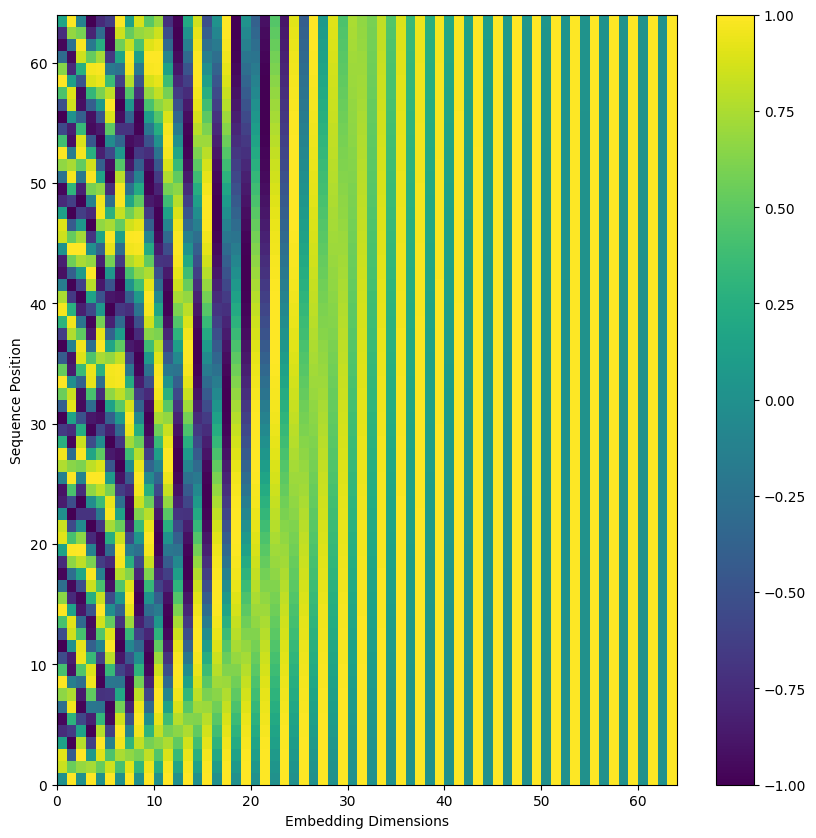

In [30]:
# Run this to plot the positional encodings values
def plot_positional_encodings(pos_encodings):
    plt.figure(figsize=(10,10))
    plt.pcolormesh(pos_encodings.detach().cpu().numpy(), cmap='viridis')
    plt.xlabel('Embedding Dimensions')
    plt.ylabel('Sequence Position')
    plt.colorbar()
    plt.show()

# Generate some positional encodings
config = ModelConfig(d_embed=64, n_ctx=32)
pos_embed = SinCosPosEmbed(config)
pos_encodings = pos_embed(torch.zeros((1, 64)).long().to(device))

plot_positional_encodings(pos_encodings)

### Question: (5 points)
Describe briefly what is shown in the heatmap (you should verify that the first value is unique and the last value is the same for each positional encoding vector).\
What is the reason for the unique first value (the 0th element in the embedding vector) of each positional encoding in the given heatmap?\
What is the reason for the same last value of each positional encoding?

### Answer:

This heatmap shows how the positional encoding is made, as vectors of sinusoide signals of decreasing frequency along the embedding dimensions. The first embedding dimension encodes the positions so that each of them will have a different value, which will be the most informative value. Mathematically, it takes unique values because the frequancy of the sinusoide is really high.

The last value of each positional ecoding seems to be the same, beacause of the really low frequency of the signal. The values actually should be slightly different, while staying close to 0.

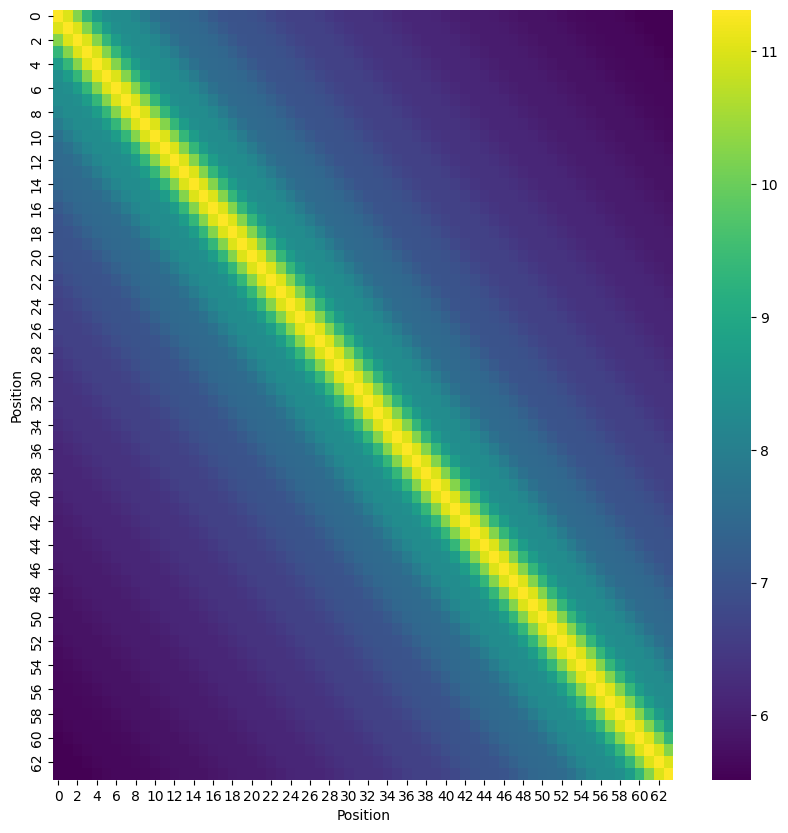

In [31]:
# Run this to plot the dot product of all positional encodings
def plot_scaled_dot_products(pos_encodings):
    # Calculate the scaled dot products
    dot_products = torch.matmul(pos_encodings, pos_encodings.transpose(0, 1)) / np.sqrt(pos_encodings.shape[1])

    # Convert to numpy
    dot_products = dot_products.detach().cpu().numpy()

    # Plot the heatmap
    plt.figure(figsize=(10,10))
    sns.heatmap(dot_products, cmap='viridis')
    plt.xlabel('Position')
    plt.ylabel('Position')
    plt.show()

# Generate some positional encodings
config = ModelConfig(d_embed=512, n_ctx=1024)
pos_embed = SinCosPosEmbed(config)
pos_encodings = pos_embed(torch.zeros((1, 64)).long().to(device))

# Plot the scaled dot products
plot_scaled_dot_products(pos_encodings)

### Question: (10 points)
Plot the dot product of all positional encodings, and describe how the model makes use of the displayed information.

### Answer:

There is a high positional correlation for words being close, but the sinusoide nature of the positional ecnoding let appear "waves" in the plot of the dot product. 